<a href="https://colab.research.google.com/github/Rickymtl/tabs-maker/blob/main/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This noteboke saves my progress in trying to use spectrogram to visualize and transcribe music. \
However, it seems the frequency resolution of it is not clear enough for pitch detection.\
for example, the frequency difference of low notes (E2:82.41Hz and F2:87.31Hz) are too close to determine on spectrogram.

In [ ]:
!pip install spleeter noisereduce librosa pydub

In [1]:
import noisereduce as nr
import librosa
import soundfile as sf
from pydub import AudioSegment
from IPython.display import Audio, display
from spleeter.separator import Separator
import os
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

# here replace with desired file path
original_audio = '/content/gdrive/MyDrive/test/SCOM.mp3'
segment = f"{original_audio.split('.')[0]}/segment.mp3"
segment_wav = f"{segment.split('.')[0]}.wav"


Mounted at /content/gdrive


## unmodified spectrogram

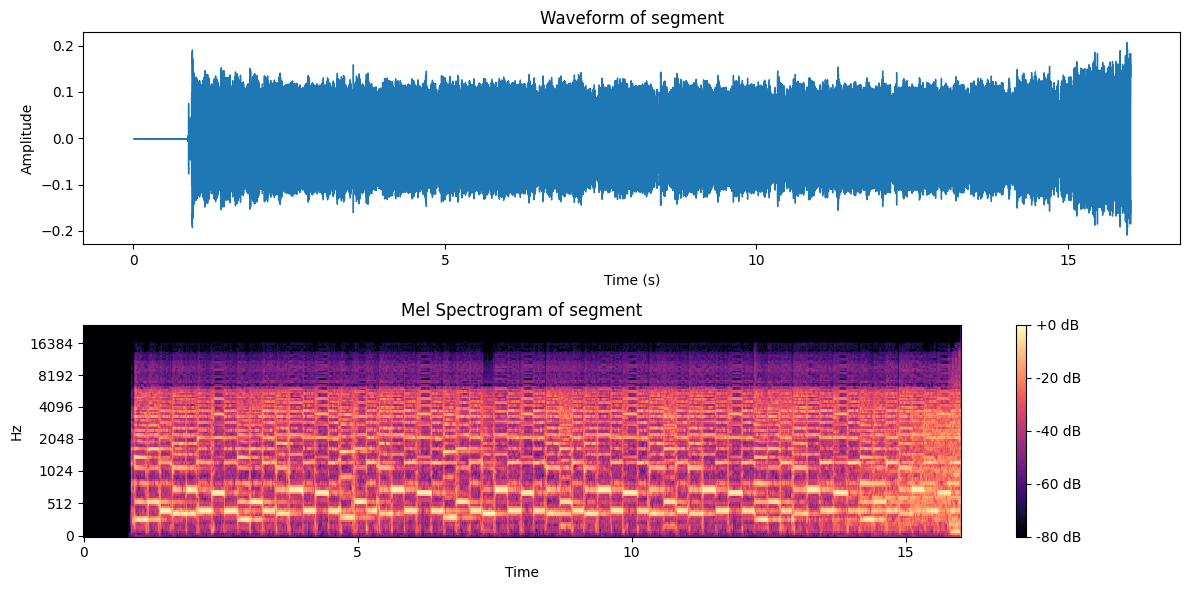

In [2]:
def plot_waveform_and_spectrogram(audio_path, title):
    # this is the most barebone module
    # to create specttrogram, need tuning on top of this

    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    plt.figure(figsize=(12, 6))

    # Plot waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform of {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    plt.subplot(2, 1, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram of {title}')
    plt.tight_layout()

    plt.show()

plot_waveform_and_spectrogram(segment, 'segment')

## tweaking
we can further tweak the spectrogram so that its easier to find midi notes.

### beat alignment

Although we could clearly see some semblance of note in the spectrogram, the default output does not look clear. \
The first idea is to align the peroid for fourier transform with the beats of music.\
We use `librosa.beat.beatrack` for BPM estimation istead of manual input.\
Also, we could plot the beats on the spectrogram.

In [3]:
# think of ways to tune the spectrogram
# should align the bpm and the step of the spectrogram
# so we align steps with beats

def get_bpm(audio_path):
    # return the bpm of given audio
    y, sr = librosa.load(audio_path, sr=None)
    # return the bpm estimate by librosa
    return librosa.beat.beat_track(y=y, sr=sr)[0][0]

def get_beat_times(audio_path):
    # return time of each beat of audio
    y, sr = librosa.load(audio_path, sr=None)
    # return the beat times by librosa
    beat_frames = librosa.beat.beat_track(y=y, sr=sr)[1]
    return librosa.frames_to_time(beat_frames, sr=sr)


In [4]:
def compute_spectrogram_to_beat(audio_path, sr=None):
    # instead of using the librosa included feateures,
    # we could tweak the parameters for more resolution

    # Load audio
    y, sr = librosa.load(audio_path, sr=sr)

    # find the bpm estimate by librosa
    BPM = get_bpm(audio_path)
    beats_per_second = BPM / 60
    time_per_beat = 1 / beats_per_second  # in seconds
    samples_per_beat = sr * time_per_beat


    # Compute the spectrogram
    n_fft = int(samples_per_beat/8)  # window size for the FFT
    print(f"n_fft: {n_fft}")
    hop_length = int(samples_per_beat / 8)  # half a beat overlap
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    # Convert amplitude to dB
    S_DB = librosa.amplitude_to_db(D, ref=np.max)

    # Compute Mel spectrogram
    # S = librosa.feature.melspectrogram(y=y, sr=sr)
    # S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB, sr, n_fft, hop_length

n_fft: 2880


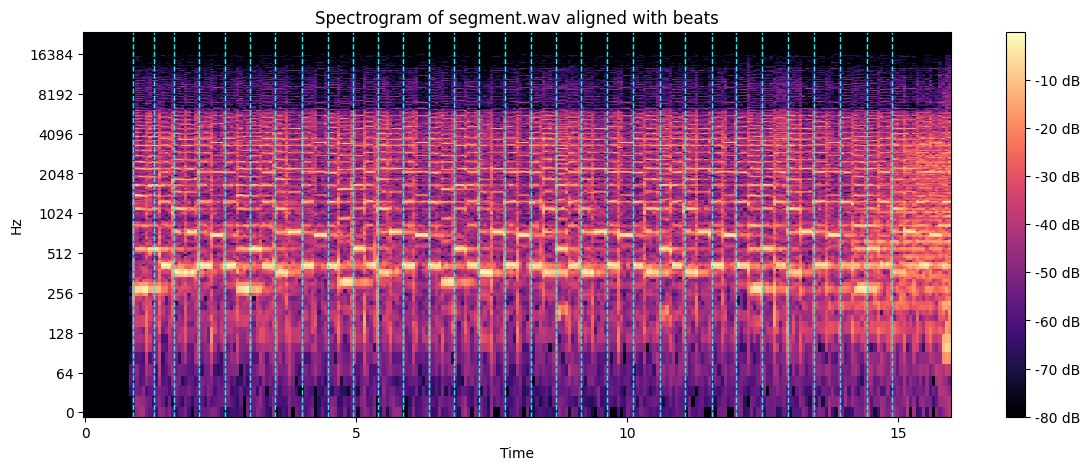

In [5]:
def plot_beat_aligned_spectrogram(audio_path):
    # compute spectrogram
    S_DB, sr, n_fft, hop_length = compute_spectrogram_to_beat(audio_path)
    beat_times = get_beat_times(audio_path)
    # Convert beat frames to time
    # beat_times = librosa.frames_to_time(beat_frames, sr=sr)

    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {audio_path.split("/")[-1]} aligned with beats')
    # Add vertical lines at the beat times
    for beat in beat_times:
        plt.axvline(x=beat, color='cyan', linestyle='--', linewidth=1)
    plt.show()

plot_beat_aligned_spectrogram(segment_wav)

next we focus on the details of fft for better frequency resolution


125.0


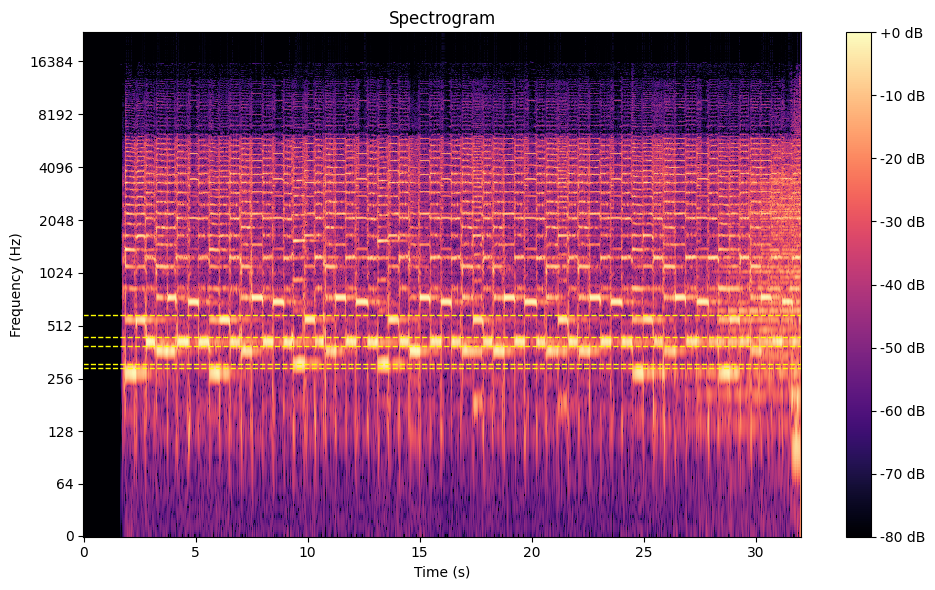

In [6]:
# Function to plot the spectrogram
# notes_freqs = [82.41, 87.31, 92.5, 98.0, 103.83, 110.0, 116.54, 123.47, 130.81, 138.59,
#  146.83, 155.56, 164.81, 174.61, 185.0, 196.0, 207.65, 220.0, 233.08,
#  246.94, 261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.0,
#  415.3, 440.0, 466.16, 493.88, 523.25, 554.37, 587.33, 622.25, 659.25,
#  698.46, 739.99, 783.99, 830.61, 880.0, 932.33, 987.77, 1046.5, 1108.73,
#  1174.66, 1244.51, 1318.51]
# add some example note frequencies to seee on the graph
notes_freqs = [293.66, 587.33, 392, 440, 311.13]

def raw_spectrogram(audio_path):

  y, sr = librosa.load(audio_path, sr=None)
  # Compute the Short-Time Fourier Transform (STFT) to get the spectrogram
  S = np.abs(librosa.stft(y, n_fft=16384, window="hamming", win_length=2048, hop_length=256))
  # Convert to decibel (dB) scale for better visualization
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  return S_db, sr

def plot_spectrogram(S_db, sr, beat_times=[]):
    plt.figure(figsize=(10, 6))


    # Plot the dB-scaled spectrogram
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')

    # Add a color bar and labels
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    # Show the plot
    plt.tight_layout()
    # for beat in beat_times:
    #     plt.axvline(x=beat, color='cyan', linestyle='--', linewidth=1)

    for note in notes_freqs:
        plt.axhline(y=note, color='yellow', linestyle='--', linewidth=1)
    plt.show()

S_db, sr = raw_spectrogram(segment_wav)
# beat_times = get_beat_times(segment_wav)
BPM = get_bpm(segment_wav)
print(BPM)
beat_time = get_beat_times(segment_wav)[0]
beat_times = []
while beat_time < 16:
    beat_times.append(beat_time)
    beat_time += 1 / (BPM/60)

plot_spectrogram(S_db, sr, beat_times)

The frequency resolution is not good enough for pitch detection.

# filter

Also, we could use use a simple filter to only focus on the higest values in the spectrogram.\
Also, we could ignore the frequencies outside of a guitar's voicing range for now.\
However, data on higher frequencies could be helpful as indication of harmonics.

S_DB shape: (8193, 3001)
S_DB max: 0.0
S_DB min: -80.0
S_DB mean: -64.98831939697266
S_DB std: 18.238100051879883
S_DB 25th percentile: -80.0
S_DB 75th percentile: -52.248863220214844


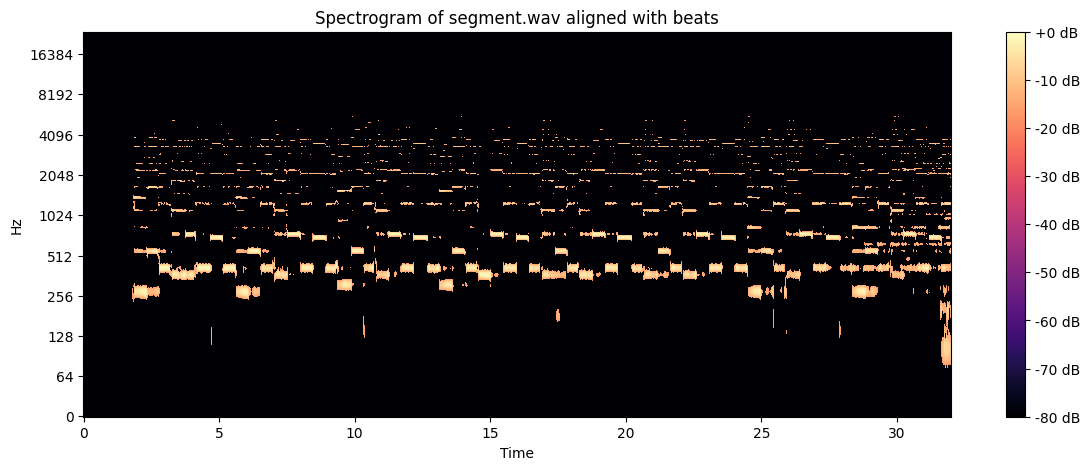

In [8]:
def filtered_spectrogram(audio_path):
    # compute spectrogram
    S_DB, sr = raw_spectrogram(audio_path)
    # display some stats of the S_DB matrix
    print(f"S_DB shape: {S_DB.shape}")
    print(f"S_DB max: {S_DB.max()}")
    print(f"S_DB min: {S_DB.min()}")
    print(f"S_DB mean: {S_DB.mean()}")
    print(f"S_DB std: {S_DB.std()}")
    # also show the 25th and 75th percentile
    print(f"S_DB 25th percentile: {np.percentile(S_DB, 25)}")
    print(f"S_DB 75th percentile: {np.percentile(S_DB, 75)}")

    # filter the matrix and set every value below 99th percentile to min
    S_DB[S_DB < np.percentile(S_DB, 99)] = S_DB.min()

    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {audio_path.split("/")[-1]} aligned with beats')
    plt.show()

filtered_spectrogram(segment_wav)

Still, the resolution issue is not fixed